In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

#save my life
#from google.colab import drive
#drive.mount("/content/drive")

In [ ]:
#training parameters
nb_experiments = 3
nb_epochs_per_acquisition = 100
batch_size = 30
eval_batch_size=256
validation_set_size = 100
dropout_samples = 100
acquisition_iters = 100
points_acquire = 10

#model parameters
nb_filters = 32
nb_classes = 10
filter_size = 4
pool_size = 2
dense_size = 128
dropout_prob_1 = 0.25
dropout_prob_2 = 0.5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define our model:
class BayesianCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, nb_filters, kernel_size=filter_size, padding=0)
    self.conv2 = nn.Conv2d(nb_filters, nb_filters, kernel_size=filter_size, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=pool_size)
    self.dropout1 = nn.Dropout(p=dropout_prob_1)

    self.full1 = nn.Linear(32 * 11 * 11, dense_size)
    self.dropout2 = nn.Dropout(p=dropout_prob_2)
    self.ln1 = nn.LayerNorm(dense_size)
    self.full2 = nn.Linear(dense_size, nb_classes)

  def features(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    x = F.relu(self.full1(x))
    x = self.dropout2(x)
    x = self.ln1(x)
    return x

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    x = F.relu(self.full1(x))
    x = self.dropout2(x)
    x = self.ln1(x)
    x = self.full2(x)
    return x


In [ ]:
@torch.no_grad()
def eval_model_per_point(model, X_test, y_test, device):
  model = model.to(device)
  model.eval()

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  out = model(X_test)
  y_onehot = F.one_hot(y_test, num_classes=10).float()
  err = ((out - y_onehot) ** 2).sum(dim=1)

  return err.detach().cpu().tolist()


@torch.no_grad()
def eval_model(model, X_test, y_test, device):
  model = model.to(device)
  model.eval()

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  out = model(X_test)
  y_onehot = torch.nn.functional.one_hot(y_test, num_classes=10).float()
  sse = torch.sum((out - y_onehot) ** 2)
  total = y_onehot.numel()

  return (sse / total).sqrt().item()


def train_model(model, X, y, X_val, y_val, optimizer, criterion, batch_size, device, nb_epochs):
  model.train()
  model.to(device)

  dloader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=batch_size)
  patience = 10
  best_val_rmse = 10000
  bad_epochs = 0
  best_state = None

  for epoch in range(nb_epochs):
    model.train()
    train_sse = 0.0
    train_total = 0
    for x, y in dloader:
      x = x.to(device)
      y_onehot = torch.nn.functional.one_hot(y, num_classes=10).float()
      y_onehot = y_onehot.to(device)

      optimizer.zero_grad()
      output = model(x)
      mse = criterion(output, y_onehot)
      mse.backward()
      optimizer.step()

      train_sse += torch.sum((output.detach() - y_onehot) ** 2).item()
      train_total += y_onehot.numel()

    verbose = False

    if verbose:
     train_rmse = (train_sse / train_total) ** 0.5
     print(f"Train rmse {train_rmse}")

    #this was adopted from classification
    #so we need to change the criteria
    early_stopping = True
    if early_stopping:
      val_rmse = eval_model(model, X_val, y_val, device)
      model.train()
      if verbose:
        print(f"Epoch {epoch+1}: val rmse: {val_rmse}")

      if val_rmse <  best_val_rmse:
        best_val_rmse = val_rmse
        bad_epochs = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
      else:
        bad_epochs += 1
        if bad_epochs >= patience:
          print(f"Early stopping at epoch {epoch+1}")
          break

  if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


  return model




In [ ]:
def sample_from_pool(X_pool, y_pool, seed=None):
  if seed is None:
    g = None
  else:
    g = torch.Generator(device=y_pool.device)
    g.manual_seed(seed)

  indices = []
  for label in range(nb_classes):
    class_indices = (y_pool == label).nonzero(as_tuple=True)[0]
    perm = torch.randperm(len(class_indices), generator=g, device=class_indices.device)
    class_indices = class_indices[perm]
    indices.append(class_indices[:2])
  return torch.cat(indices, dim=0)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X = torch.stack([train[i][0] for i in range(len(train))])
y = torch.tensor([train[i][1] for i in range(len(train))])

X_test = torch.stack([test[i][0] for i in range(len(test))])
y_test = torch.tensor([test[i][1] for i in range(len(test))])


100%|██████████| 9.91M/9.91M [00:00<00:00, 40.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


# Acquisition function: Predictive Variance

In [ ]:
def compute_pred_variance_MC_dropout(model, X_pool_red, device, X_train, y_train, s, sigma):
  #params copied
  dropout_samples=200
  batch_size=256
  nb_classes=10
  sigma = sigma

  model = model.to(device)
  model.train()

  #we dont care abt sigma since it doesnt change the ranking,

  N = X_pool_red.size(0)
  X_pool_red = X_pool_red.to(device)
  mean_samples = torch.zeros((N, nb_classes), device=device)
  var_samples = torch.zeros((N, nb_classes, nb_classes), device=device)

  dropout_samples = 1000
  with torch.no_grad():
    for _ in range(dropout_samples):
      outps = model(X_pool_red)
      mean_samples += outps
      var_samples+= outps.unsqueeze(2) * outps.unsqueeze(1) #snd moment

  mean_samples = mean_samples / dropout_samples
  var_samples = var_samples / dropout_samples - (mean_samples.unsqueeze(2) * mean_samples.unsqueeze(1))
  var_samples = var_samples + (sigma ** 2) * torch.eye(nb_classes, device=device).unsqueeze(0)

  ret = torch.diagonal(var_samples, dim1=1, dim2=2).sum(-1) #trace
  return ret

In [ ]:
def compute_random(model, X_pool_red, device, X_train, y_train,s,sigma):
  return torch.rand(X_pool_red.shape[0])

In [ ]:
  import plotly.express as px
  import polars as pl

In [ ]:
def get_score_err_plots(X, y, X_test, y_test, acquisitions = None):
  perm = torch.randperm(len(X))
  X = X[perm]
  y = y[perm]
  X_valid = X[:validation_set_size]
  y_valid = y[:validation_set_size]
  X_pool_orig = X[validation_set_size:]
  y_pool_orig = y[validation_set_size:]
  train_idx = sample_from_pool(X_pool_orig, y_pool_orig)
  acq = 0

  for acq in range(len(acquisitions)):
    acq_func = acquisitions[acq][0]
    acq_name = acquisitions[acq][1]
    print(f'Creating training dataset')

    X_train = X_pool_orig[train_idx]
    y_train = y_pool_orig[train_idx]

    mask = torch.ones(len(X_pool_orig), dtype=torch.bool)
    mask[train_idx] = False
    X_pool = X_pool_orig[mask]
    y_pool = y_pool_orig[mask]


    md = None
    accs = []
    stats = {i:0 for i in range(10)}
    s = 0.5
    sigma = 0.1
    N = X_train.shape[0]
    print(f"Now X is of size {N}")


    modelAct = BayesianCNN()
    optimizer = torch.optim.Adam(modelAct.parameters(), lr=0.001)#weight_decay = 2 * (sigma**2) / (N * (s**2)))
    criterion = nn.MSELoss()

    #train on the current training set
    modelAct = train_model(modelAct, X_train, y_train, X_valid, y_valid, optimizer, criterion, batch_size=batch_size, device=device, nb_epochs=nb_epochs_per_acquisition)

    #get BALD for all or almost all pool points?
    idx = torch.randperm(X_pool.size(0))[:1000]
    X_pool_red = X_pool[idx]
    y_pool_red = y_pool[idx]

    scores = acq_func(modelAct, X_pool_red, device, X_train, y_train,s,sigma)
    err = eval_model_per_point(modelAct, X_pool_red, y_pool_red, device)
    true_class = y_pool_red


    df = pl.DataFrame({"scores": scores.cpu().detach().numpy(), "err": err, "true_class": true_class.cpu().numpy()})

    fig = px.scatter(df, x="scores", y="err", color="true_class")
    fig.show()

In [ ]:
def run_experiment_regression(X, y, X_test, y_test, acquisitions = None):
  perm_g = torch.Generator()
  perm = torch.randperm(len(X), generator=perm_g)
  X = X[perm]
  y = y[perm]
  X_valid = X[:validation_set_size]
  y_valid = y[:validation_set_size]
  X_pool_orig = X[validation_set_size:]
  y_pool_orig = y[validation_set_size:]
  train_idx = sample_from_pool(X_pool_orig, y_pool_orig)

  accs_for_acquisitons = [[] for _ in range(len(acquisitions))]
  for acq in range(len(acquisitions)):

    print(f'Creating training dataset')
    X_train = X_pool_orig[train_idx]
    y_train = y_pool_orig[train_idx]

    mask = torch.ones(len(X_pool_orig), dtype=torch.bool)
    mask[train_idx] = False
    X_pool = X_pool_orig[mask]
    y_pool = y_pool_orig[mask]


    print(f'Active learning: running for {acquisitions[acq][1]}')
    acq_name = acquisitions[acq][1]
    acq_func = acquisitions[acq][0]
    md = None
    accs = []
    stats = {i:0 for i in range(10)}

    for i in range(100):
      if i % 10 == 0:
        print(f'Starting acquisition iteration {i}')

      N = X_train.shape[0]
      s = 0.5
      sigma = 0.1
      modelAct = BayesianCNN()
      optimizer = torch.optim.Adam(modelAct.parameters(), lr=0.001,weight_decay = 2 * (sigma**2) / (N * (s**2)))
      criterion = nn.MSELoss()

      #train on the current training set
      modelAct = train_model(modelAct, X_train, y_train, X_valid, y_valid, optimizer, criterion, batch_size=batch_size, device=device, nb_epochs=nb_epochs_per_acquisition)

      #get BALD for all or almost all pool points?
      idx = torch.randperm(X_pool.size(0))[:1000]
      X_pool_red = X_pool[idx]
      y_pool_red = y_pool[idx]

      score = acq_func(modelAct, X_pool_red, device, X_train, y_train, s, sigma)

      Queries = points_acquire

      topk_in_red = torch.topk(score, k=Queries).indices.to("cpu")
      chosen_idx = idx[topk_in_red]
      #for i in range(10):
      #  showimg(X_pool[chosen_idx[i]])
      #get statistics of classes chosen so far:
      for i in y_pool[chosen_idx]:
        stats[i.item()] += 1
      print(stats)



      X_train = torch.cat([X_train, X_pool[chosen_idx]], dim=0)
      y_train = torch.cat([y_train, y_pool[chosen_idx]], dim=0)

      mask = torch.ones(X_pool.size(0), dtype=torch.bool)
      mask[chosen_idx] = False
      X_pool = X_pool[mask]
      y_pool = y_pool[mask]

      rmse = eval_model(modelAct, X_test, y_test, device)
      modelAct.train()
      accs.append((rmse, X_train.shape[0] - Queries))
      print(f'RMSE: {rmse}')
      md = modelAct


    now = datetime.now()
    #save_path = "/content/drive/MyDrive/" + str(now.hour) + str(now.minute) + acq_name + "bayesian_cnn_mnist.pt"
    #torch.save(md.state_dict(), save_path)

    accs_for_acquisitons[acq] = accs

  return accs_for_acquisitons

# Entry point

In [ ]:
funcs = [[compute_pred_variance_MC_dropout, "pred_variance_naive"],[compute_random, "random"]]#[compute_predictive_variance_idid, "pred_variance_naive"], [compute_random, "random"]]
#get_score_err_plots(X, y, X_test, y_test, funcs)
results1 = run_experiment_regression(X, y, X_test, y_test, funcs)
results2 = run_experiment_regression(X, y, X_test, y_test, funcs)
results3 = run_experiment_regression(X, y, X_test, y_test, funcs)

avg_regression_results = []
for i in range(2):
  avg_regression_results.append([])
  for j in range(100):
    avg_regression_results[i].append([(results1[i][j][0] + results2[i][j][0] + results3[i][j][0]) / 3, results1[i][j][1]])


import json
with open("/content/drive/MyDrive/regression_results_predvar1.json", "w") as f:
  json.dump(results1, f)
with open("/content/drive/MyDrive/regression_results_predvar2.json", "w") as f:
  json.dump(results2, f)
with open("/content/drive/MyDrive/regression_results_predvar3.json", "w") as f:
  json.dump(results3, f)
with open("/content/drive/MyDrive/regression_results_predvar_avg.json", "w") as f:
  json.dump(avg_regression_results, f)


Creating training dataset
Active learning: running for pred_variance_naive
Starting acquisition iteration 0
Early stopping at epoch 27
{0: 1, 1: 5, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 2, 9: 1}
RMSE: 0.28829145431518555
Early stopping at epoch 35
{0: 3, 1: 12, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 2, 9: 1}
RMSE: 0.28598177433013916
Early stopping at epoch 48
{0: 9, 1: 12, 2: 0, 3: 0, 4: 2, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2}
RMSE: 0.2755732238292694
Early stopping at epoch 53
{0: 18, 1: 12, 2: 0, 3: 0, 4: 2, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
RMSE: 0.2720244824886322
Early stopping at epoch 78
{0: 18, 1: 12, 2: 0, 3: 3, 4: 2, 5: 3, 6: 1, 7: 7, 8: 2, 9: 2}
RMSE: 0.2629287838935852
Early stopping at epoch 95
{0: 18, 1: 12, 2: 0, 3: 13, 4: 2, 5: 3, 6: 1, 7: 7, 8: 2, 9: 2}
RMSE: 0.23499035835266113
Early stopping at epoch 16
{0: 23, 1: 16, 2: 0, 3: 13, 4: 2, 5: 4, 6: 1, 7: 7, 8: 2, 9: 2}
RMSE: 0.295523464679718
{0: 23, 1: 16, 2: 0, 3: 13, 4: 2, 5: 5, 6: 9, 7: 7, 8: 2, 9: 3}
RMSE: 0.235315263271331

KeyboardInterrupt: 

In [ ]:
import json
with open("/content/drive/MyDrive/regression_results_predvar1.json", "r") as f:
  results1 = json.load(f)
with open("/content/drive/MyDrive/regression_results_predvar2.json", "r") as f:
  results2 = json.load(f)
with open("/content/drive/MyDrive/regression_results_predvar3.json", "r") as f:
  results3 = json.load(f)

avg_regression_results = []
for i in range(2):
  avg_regression_results.append([])
  for j in range(140):
    avg_regression_results[i].append([(results1[i][j][0] + results2[i][j][0] + results3[i][j][0]) / 3, results1[i][j][1]])

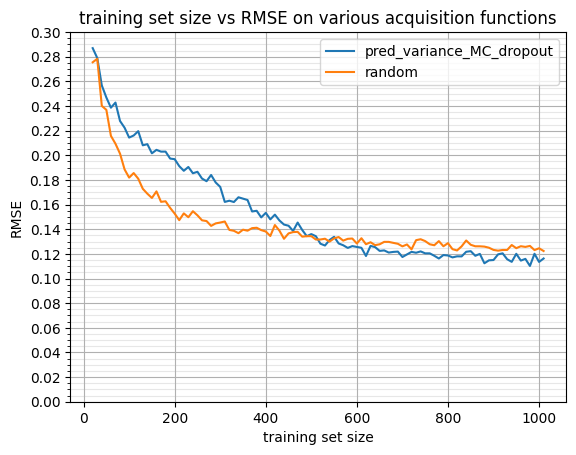

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter
names =  ["pred_variance_MC_dropout", "random"]
for i in range(2):
  accs = avg_regression_results[i]
  plt.plot([acc[1] for acc in accs], [acc[0] for acc in accs], label=names[i])


ax = plt.gca()
ax.set_ylim(0.0, 0.3)

ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))

ax.grid(True, which="major")
ax.grid(True, which="minor", alpha=0.3)

plt.title("training set size vs RMSE on various acquisition functions")
plt.xlabel("training set size")
plt.ylabel("RMSE")
plt.legend()
plt.show()